# Importing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [304]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm


Using Dataset_2 as the main training data for results

In [209]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [210]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [211]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [212]:
img_data_list = []
image_path_list = []

In [213]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

  3%|▎         | 28/1000 [00:00<00:03, 278.56it/s]

Loading the images of dataset - Covid-19



  4%|▎         | 37/1000 [00:00<00:02, 364.31it/s]

Loading the images of dataset - Normal



  3%|▎         | 33/1000 [00:00<00:02, 323.85it/s]

Loading the images of dataset - Pneumonia



 77%|███████▋  | 772/1000 [00:02<00:00, 325.78it/s]


In [214]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(2400, 224, 224, 3)


In [215]:
len(image_path_list)

2400

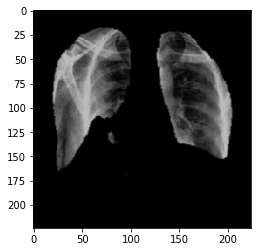

In [216]:
plt.imshow(img_data[500])

In [217]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [218]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [219]:
labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [220]:
labels.shape

(2400,)

In [221]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [222]:
X_test_NN.shape

(480, 224, 224, 3)

In [223]:
X_train_NN.shape

(1920, 224, 224, 3)

In [224]:
y_train_NN.shape

(1920, 3)

## Training

90

In [225]:
import tensorflow as tf
# shape 224, 224, 3

In [19]:
VGG_16 = tf.keras.applications.VGG16(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

In [21]:
VGG_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = VGG_16.get_layer('flatten').output
x = Dense(4096, activation='relu', name='fc1')(last_layer)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(VGG_16.input, out)

In [23]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [24]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [25]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [26]:
custom_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [27]:
from tensorflow.keras.applications.vgg16 import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [28]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('VGG_16.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [29]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 17s 276ms/step - loss: 19.1828 - accuracy: 0.7609 - val_loss: 0.2538 - val_accuracy: 0.9458
Epoch 2/100
60/60 [==============================] - 34s 567ms/step - loss: 0.2542 - accuracy: 0.9354 - val_loss: 0.2257 - val_accuracy: 0.9458
Epoch 3/100
60/60 [==============================] - 32s 535ms/step - loss: 0.0614 - accuracy: 0.9828 - val_loss: 0.0880 - val_accuracy: 0.9646
Epoch 4/100
60/60 [==============================] - 10s 158ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.1163 - val_accuracy: 0.9646
Epoch 5/100
60/60 [==============================] - 10s 160ms/step - loss: 0.0071 - accuracy: 0.9969 - val_loss: 0.1254 - val_accuracy: 0.9667
Epoch 6/100
60/60 [==============================] - 10s 162ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9604
Epoch 7/100
60/60 [==============================] - 10s 164ms/step - loss: 5.2313e-04 - accuracy: 1.0000 - val_loss: 0.1198 - val_accu

In [30]:
classifier = tf.keras.models.load_model("VGG_16.h5")

In [31]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[159   0   2]
 [  0 163   4]
 [  2   9 141]]


In [32]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.95      0.98      0.96       167
           2       0.96      0.93      0.94       152

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



###Testing the model with ML techniques

In [20]:
classifier = tf.keras.models.load_model("VGG_16.h5")

In [21]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [22]:
Model_new.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [23]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [24]:
from tensorflow.keras.applications.vgg16 import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [25]:
y_train_1.shape

(1350,)

In [26]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[ 0.        0.        0.       ...  0.       66.120834  0.      ]
 [ 0.        0.        0.       ...  0.       26.78938   0.      ]
 [ 0.        0.        0.       ...  0.       70.956116  0.      ]
 ...
 [ 0.        0.        0.       ...  0.       80.1613    0.      ]
 [ 0.        0.        0.       ...  0.       24.360495  0.      ]
 [ 0.        0.        0.       ...  0.       31.288465  0.      ]]


In [27]:
test_new.shape

(150, 256)

#### svm

94 and 90

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9925925925925926

fc3

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 1 47  2]
 [ 0  2 45]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.96      0.94      0.95        50
           2       0.96      0.96      0.96        47

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



#### xg_boost

92 and 91

In [30]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 1 46  3]
 [ 0  1 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.98      0.92      0.95        50
           2       0.94      0.98      0.96        47

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



#### random forest

93 and 90

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 1 46  3]
 [ 0  2 45]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        53
           1       0.96      0.92      0.94        50
           2       0.94      0.96      0.95        47

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



# Descriptors Extraction and Training

## Preprocessing the Data

In [77]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Using: SIFT

In [78]:
import cv2

In [79]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [80]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:44<00:00, 53.79it/s]


In [81]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

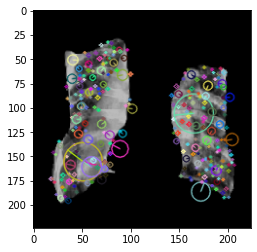

In [82]:
plt.imshow(image)
plt.show()

Using BRISK

In [226]:
import cv2

In [227]:
brisk = cv2.BRISK_create(50)
des_list = []

In [228]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:06<00:00, 347.48it/s]


In [229]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

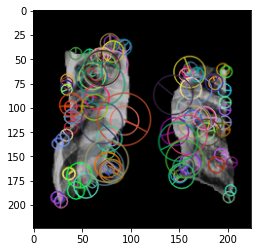

In [230]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [231]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 2400/2400 [00:02<00:00, 911.75it/s]


In [232]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [233]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [234]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 2400/2400 [00:01<00:00, 1476.71it/s]


performing Tf-Idf vectorization

In [235]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [236]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [237]:
im_features.shape

(2400, 128)

In [238]:
im_features.dtype

dtype('float32')

## Train and Test spliting 

In [239]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [240]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [241]:
X_train_d.shape

(2040, 128)

In [242]:
y_train_d.shape

(2040,)

## Training with SIFT

### Training on SVM

In [95]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [96]:
svm.score(X_train_d,y_train_d)

0.9529411764705882

In [97]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[110   0   8]
 [  1 119  17]
 [ 13   7  85]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       118
           1       0.94      0.87      0.90       137
           2       0.77      0.81      0.79       105

    accuracy                           0.87       360
   macro avg       0.87      0.87      0.87       360
weighted avg       0.88      0.87      0.87       360



### Training on XG_boost

In [98]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [99]:
xb.score(X_train_d,y_train_d)

0.9446078431372549

In [100]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[100   5  13]
 [  2 122  13]
 [ 12   6  87]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       118
           1       0.92      0.89      0.90       137
           2       0.77      0.83      0.80       105

    accuracy                           0.86       360
   macro avg       0.85      0.86      0.85       360
weighted avg       0.86      0.86      0.86       360



### Training on Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [102]:
rf.score(X_train_d,y_train_d)

1.0

In [103]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 88   4  26]
 [  1 123  13]
 [ 13  10  82]]
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       118
           1       0.90      0.90      0.90       137
           2       0.68      0.78      0.73       105

    accuracy                           0.81       360
   macro avg       0.81      0.81      0.81       360
weighted avg       0.82      0.81      0.82       360



## Training with BRISK

### Training on SVM

In [243]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [244]:
svm.score(X_train_d,y_train_d)

0.8735294117647059

In [245]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 87  10  21]
 [  2 111  24]
 [ 11  12  82]]
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       118
           1       0.83      0.81      0.82       137
           2       0.65      0.78      0.71       105

    accuracy                           0.78       360
   macro avg       0.78      0.78      0.78       360
weighted avg       0.79      0.78      0.78       360



### Training on XG_boost

In [246]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [247]:
xb.score(X_train_d,y_train_d)

0.8642156862745098

In [248]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83 10 25]
 [ 3 98 36]
 [15 18 72]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       118
           1       0.78      0.72      0.75       137
           2       0.54      0.69      0.61       105

    accuracy                           0.70       360
   macro avg       0.71      0.70      0.70       360
weighted avg       0.72      0.70      0.71       360



### Training on Random Forest

In [249]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [250]:
rf.score(X_train_d,y_train_d)

1.0

In [251]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 84   9  25]
 [  3 104  30]
 [ 14  18  73]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       118
           1       0.79      0.76      0.78       137
           2       0.57      0.70      0.63       105

    accuracy                           0.73       360
   macro avg       0.73      0.72      0.72       360
weighted avg       0.74      0.72      0.73       360



# Combining all the Processes

In [252]:
import tensorflow as tf

In [253]:
Model_s = tf.keras.models.load_model("VGG_16.h5")

In [254]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [255]:
Model_C.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [256]:
from tensorflow.keras.applications.vgg16 import preprocess_input
img_data = preprocess_input(img_data)

In [257]:
Pred_fc3 = Model_C.predict(img_data)

In [258]:
Pred_fc3.shape

(2400, 256)

In [259]:
Pred_fc3.dtype

dtype('float32')

In [260]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [261]:
im_features.shape

(2400, 128)

In [262]:
im_features.dtype

dtype('float32')

In [263]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [264]:
total_features = 384

In [265]:
total_dataset = 2400

In [266]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [267]:
feature_data.shape

(2400, 384)

In [268]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 2400/2400 [00:00<00:00, 209135.72it/s]


In [269]:
feature_data

array([[ 1.4815084 , -0.74024135,  1.7031865 , ...,  0.        ,
        97.43988   ,  0.        ],
       [ 3.5916686 , -0.74024135, -0.20070153, ...,  0.        ,
        72.11748   ,  0.        ],
       [-0.6286519 ,  2.0198507 , -0.83533084, ...,  0.        ,
        69.44652   ,  0.        ],
       ...,
       [-0.6286519 , -0.74024135, -0.83533084, ...,  0.        ,
        27.560495  ,  0.        ],
       [-0.6286519 , -0.74024135, -0.20070153, ...,  0.        ,
        29.570778  ,  0.        ],
       [ 2.5365884 , -0.74024135, -0.20070153, ...,  0.        ,
        37.516426  ,  0.        ]], dtype=float32)

Train Test split

change accordance to the type of training

In [270]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [271]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [272]:
X_train_c.shape

(1920, 384)

In [273]:
y_train_c.shape

(1920, 3)

## Training DL model

In [274]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [275]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [276]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [277]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [278]:
model_combined.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                

In [279]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('VGG_16_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [280]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 0s 6ms/step - loss: 1.4007 - accuracy: 0.8083 - val_loss: 0.1429 - val_accuracy: 0.9521
Epoch 2/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.1723 - val_accuracy: 0.9563
Epoch 3/100
60/60 [==============================] - 0s 5ms/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.1355 - val_accuracy: 0.9667
Epoch 4/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0606 - accuracy: 0.9781 - val_loss: 0.1548 - val_accuracy: 0.9500
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9927 - val_loss: 0.1240 - val_accuracy: 0.9583
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.2133 - val_accuracy: 0.9667
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.9964 - val_loss: 0.1579 - val_accuracy: 0.9667
Epoch 8/100
6

In [281]:
Model_n = tf.keras.models.load_model("VGG_16_combined_BRISK.h5")

In [282]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[158   0   3]
 [  0 161   6]
 [  2   9 141]]


In [283]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       161
           1       0.95      0.96      0.96       167
           2       0.94      0.93      0.93       152

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



SIFT ACCURACY was 97%

## Using ML methods

In [284]:
Model_n = tf.keras.models.load_model("VGG_16_combined_BRISK.h5")

In [285]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [286]:
Model_csn.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)             

In [287]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [288]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[ 0.          1.5834681   3.5387166  ...  0.          3.0268247
   0.        ]
 [ 0.          0.43817532  0.6514341  ...  0.          1.2322934
   0.        ]
 [ 0.          2.2577617   4.6504884  ...  0.          6.1677504
   0.        ]
 ...
 [ 0.          4.9299846  10.841107   ...  0.          0.
   0.        ]
 [ 0.          5.43451     9.905554   ...  0.         14.323076
   0.        ]
 [ 0.          5.662796    9.824977   ...  0.         14.298838
   0.        ]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [144]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [145]:
svm.score(train_new, y_train_1)

0.9994791666666667

In [146]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 165   2]
 [  2   7 143]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.96      0.99      0.97       167
           2       0.99      0.94      0.96       152

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



#### xg_boost

In [147]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [148]:
xb.score(train_new,y_train_1)

1.0

In [149]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 159   8]
 [  2   3 147]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.98      0.95      0.97       167
           2       0.95      0.97      0.96       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



#### Random forest

In [150]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [151]:
rf.score(train_new,y_train_1)

1.0

In [152]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 159   8]
 [  2   3 147]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       161
           1       0.98      0.95      0.97       167
           2       0.95      0.97      0.96       152

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [289]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [290]:
svm.score(train_new, y_train_1)

0.9994791666666667

In [291]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[159   0   2]
 [  0 161   6]
 [  2   9 141]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.95      0.96      0.96       167
           2       0.95      0.93      0.94       152

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



#### xg_boost

In [292]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [293]:
xb.score(train_new,y_train_1)

1.0

In [294]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[159   1   1]
 [  1 160   6]
 [  2  10 140]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.94      0.96      0.95       167
           2       0.95      0.92      0.94       152

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



#### Random forest

In [295]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [296]:
rf.score(train_new,y_train_1)

1.0

In [297]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  0 160   7]
 [  2   9 141]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       0.95      0.96      0.95       167
           2       0.95      0.93      0.94       152

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



# Testing the models

## Dataset Preprocessing

In [298]:
import tensorflow as tf
import numpy as np

In [299]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [300]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [301]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [302]:
img_data_list = []
image_path_list = []

In [305]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 36%|███▋      | 33/91 [00:00<00:00, 328.56it/s]

Loading the images of dataset - Covid-19



 40%|███▉      | 36/91 [00:00<00:00, 355.41it/s]

Loading the images of dataset - Normal



 36%|███▌      | 35/97 [00:00<00:00, 346.33it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 337.85it/s]


In [306]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 224, 224, 3)


In [307]:
len(image_path_list)

280

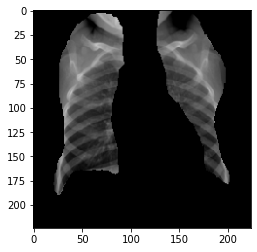

In [308]:
plt.imshow(img_data[100])

In [309]:
img_data.dtype

dtype('int32')

In [310]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [311]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [312]:
labels.shape

(279,)

In [313]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [48]:
Model_n = tf.keras.models.load_model("VGG_16.h5")

In [49]:
from tensorflow.keras.applications.vgg16 import preprocess_input
X_test = preprocess_input(X_test)

In [50]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[89  0  2]
 [ 1 85  5]
 [ 1  8 88]]


In [51]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        91
           1       0.91      0.93      0.92        91
           2       0.93      0.91      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



ML Techniques

In [52]:
classifier = tf.keras.models.load_model("VGG_16.h5")

In [53]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [54]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [55]:
from tensorflow.keras.applications.vgg16 import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [56]:
test_new_x = Model_new.predict(x_test_new)

svm

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 86  4]
 [ 3  8 86]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.91      0.95      0.93        91
           2       0.95      0.89      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



xg_boost

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[89  0  2]
 [ 1 84  6]
 [ 3  9 85]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        91
           1       0.90      0.92      0.91        91
           2       0.91      0.88      0.89        97

    accuracy                           0.92       279
   macro avg       0.92      0.93      0.93       279
weighted avg       0.92      0.92      0.92       279



random_forest

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 87  3]
 [ 2  8 87]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        91
           1       0.92      0.96      0.94        91
           2       0.96      0.90      0.93        97

    accuracy                           0.95       279
   macro avg       0.95      0.95      0.95       279
weighted avg       0.95      0.95      0.95       279



## Feature Extraction

### SIFT

In [176]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [177]:
import cv2

In [178]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [179]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:04<00:00, 57.51it/s]


In [180]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

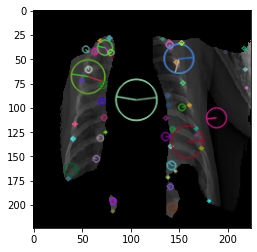

In [181]:
plt.imshow(image)
plt.show()

In [182]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 483.19it/s]


In [183]:
descriptors_float = descriptors.astype(float)

In [184]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [185]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 896.58it/s]


In [186]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [187]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [188]:
im_features.shape

(279, 128)

In [189]:
im_features.dtype

dtype('float32')

In [190]:
Model_s = tf.keras.models.load_model("VGG_16.h5")

In [191]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [192]:
from tensorflow.keras.applications.vgg16 import preprocess_input
img_data = preprocess_input(img_data)

In [193]:
Pred_fc3 = Model_C.predict(img_data)

In [194]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 50794.81it/s]


In [195]:
feature_data.shape

(279, 384)

In [196]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [197]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [198]:
Model_n = tf.keras.models.load_model("VGG_16_combined_SIFT.h5")

In [199]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[90  0  1]
 [ 1 85  5]
 [ 3  6 88]]


In [200]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.93      0.93      0.93        91
           2       0.94      0.91      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



#### ML Techniques

In [201]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [202]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [203]:
new_test_x = Model_csn.predict(x_new_test)

In [204]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [205]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 0 87  4]
 [ 3  8 86]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        91
           1       0.92      0.96      0.94        91
           2       0.95      0.89      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



xg_boost

In [206]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 85  5]
 [ 3  6 88]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.93      0.93      0.93        91
           2       0.94      0.91      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



random forest

In [207]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 85  5]
 [ 3  6 88]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.93      0.93      0.93        91
           2       0.94      0.91      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



### BRISK

In [314]:
import cv2

In [315]:
brisk = cv2.BRISK_create(50)
des_list = []

In [316]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:00<00:00, 321.56it/s]


In [317]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

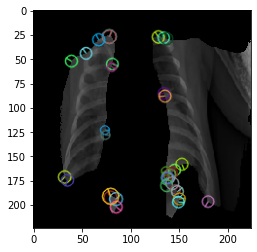

In [318]:
plt.imshow(image)
plt.show()

In [319]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 5171.84it/s]


In [320]:
descriptors_float = descriptors.astype(float)

In [321]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [322]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 1403.66it/s]


In [323]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [324]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [325]:
im_features.shape

(279, 128)

In [326]:
im_features.dtype

dtype('float32')

In [327]:
Model_s = tf.keras.models.load_model("VGG_16.h5")

In [328]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [329]:
from tensorflow.keras.applications.vgg16 import preprocess_input
img_data = preprocess_input(img_data)

In [330]:
Pred_fc3 = Model_C.predict(img_data)

In [331]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 90974.95it/s]


In [332]:
feature_data.shape

(279, 384)

In [333]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [334]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [335]:
Model_n = tf.keras.models.load_model("VGG_16_combined_BRISK.h5")

In [336]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[88  0  3]
 [ 1 85  5]
 [ 1  7 89]]


In [337]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        91
           1       0.92      0.93      0.93        91
           2       0.92      0.92      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



#### ML Techniques

In [338]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [339]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [340]:
new_test_x = Model_csn.predict(x_new_test)

In [341]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [342]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 84  6]
 [ 2  7 88]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        91
           1       0.92      0.92      0.92        91
           2       0.93      0.91      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279



xg_boost

In [343]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 87  3]
 [ 4  9 84]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        91
           1       0.91      0.96      0.93        91
           2       0.95      0.87      0.91        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.93       279



random forest

In [344]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[90  0  1]
 [ 1 85  5]
 [ 3  7 87]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        91
           1       0.92      0.93      0.93        91
           2       0.94      0.90      0.92        97

    accuracy                           0.94       279
   macro avg       0.94      0.94      0.94       279
weighted avg       0.94      0.94      0.94       279

